# Anchored CorEX Topic Modeling (Semi-Supervised)

In [1]:
# General packages
import pandas as pd

# Text Processing
import nltk
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer

# Topic Modelling
from corextopic import corextopic as ct

# Plots
import matplotlib.pyplot as plt

### Check for Spam/Duplicate comments

In [2]:
df = pd.read_csv('../Data/travel_comments.csv')
print(f"Total comments is: {len(df['Comment'])}")
print(f"Unique comments is: {len(df['Comment'].unique())}")

Total comments is: 7639
Unique comments is: 7058


### Remove Spam/Duplicates rows

In [3]:
print('Travel Comments')
print('-'*20)
print(f"Before cleaning: {len(df['Comment'])}")

df.drop_duplicates(subset=['Comment'], inplace=True)
print(f"After cleaning: {len(df['Comment'])}")

Travel Comments
--------------------
Before cleaning: 7639
After cleaning: 7058


In [13]:
print('Travel Comments')
print('-'*20)
print(f"Before cleaning: {len(df['Comment'])}")
df.dropna(subset=['Comment'], inplace=True)
print(f"After cleaning: {len(df['Comment'])}")

Travel Comments
--------------------
Before cleaning: 7058
After cleaning: 7058


# Semi-supervised Topic Modeling (CorEx)

### Creating the BOW model and all the unique words in the corpus

In [4]:
def get_corex_vectorizer_vocab(df):
    comments = []
    for row in df['Comment']:
        text_tokenize = word_tokenize(row)
        text_lower = [w.lower() for w in text_tokenize]
        text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
        text_drop_2letters = [w for w in text_words_only if len(w) > 2]
        text_joined = ' '.join(text_drop_2letters)
        comments.append(text_joined)

    df['Comment'] = comments

    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
    vectorizer = vectorizer.fit(df['Comment'])
    vecs = vectorizer.transform(df['Comment'])
    vocab = vectorizer.get_feature_names()

    return vecs, vocab

vecs, vocab = get_corex_vectorizer_vocab(df=df)
len(vocab)

64626

### Creating anchor words for CorEx model to guide words to fall into each guided topic

In [5]:
anchor_words = [
   # Topic 1: GPE
   ['singapore', 'malaysia', 'united states', 'india', 'indonesia', 'china', 'germany', 'hong kong', 'united kingdom', 'japan'],

   # Topic 2: PERSON
   ['rs lin', 'cov fox bbc', 'boba fett', 'allen chua', 'jesus', 'foreign workers', 'peter kroll', 'richard wong', 'lisa lim', 'pm lee'],

   # Topic 3: ORG
   ['moh', 'lah', 'cnn', 'cdc places', 'channel news asia', 'parliament', 'govt', 'sia', 'vote peoples action party', 'united states'],

   # Topic 4: EVENT
   ['covid', 'omicron', 'delta', 'social distancing', 'coronavirus', 'wuhan virus', 'safe distancing', 'covid variant', 'safeentry', 'circuit breaker'],
   
   # Topic 5: NORP
   ['singaporeans', 'singaporean', 'johor', 'malaysian', 'chinese', 'indian', 'indonesian', 'european', 'asian', 'african']
]

### Training the CorEx model

In [6]:
import time
start_time = time.time()

anchored_topic_model = ct.Corex(n_hidden=5, seed=2)
anchored_topic_model.fit(vecs, words=vocab, anchors=anchor_words, anchor_strength=6)

print("---Training of CorEx model completed ---")
print("Time taken: %s seconds" % (time.time() - start_time))

---Training of CorEx model completed ---
Time taken: 127.45120596885681 seconds


### Getting the top words for each topic

In [7]:
def print_corex_top_topic_words(model, n_words):
    for n in range(n_words):
        topic_words,_,_ = zip(*model.get_topics(topic = n))
        print('Topic #{}: '.format(n+1) + ', '.join(topic_words))
        print()
print_corex_top_topic_words(model=anchored_topic_model, n_words=5)

Topic #1: singapore, malaysia, united states, india, germany, indonesia, hong kong, united kingdom, japan, china

Topic #2: boba fett, allen chua, lisa lim, richard wong, jesus, foreign workers, boba, fett, wong, chua

Topic #3: united states, govt, lah, states, united, moh, parliament, cnn, like, pore govt

Topic #4: covid, omicron, delta, covid nineteen, nineteen, coronavirus, social distancing, covid cases, cases, safe distancing

Topic #5: singaporeans, singaporean, johor, malaysian, chinese, asian, indian, european, african, indonesian



### Plot the total correlation plot to check the correlation score for each topic

Text(0, 0.5, 'Total Correlation (nats)')

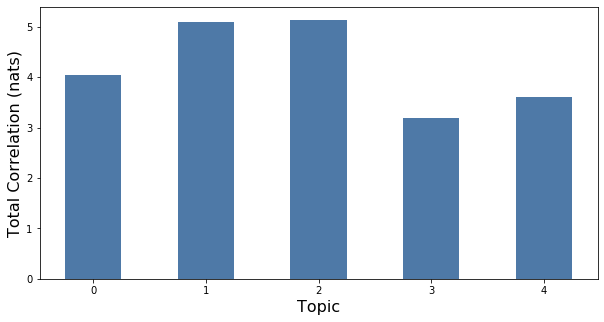

In [8]:
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)

### Label topics for each comment

In [9]:
def corex_label_topics(df, model, vecs, no_topics):
    topic_df = pd.DataFrame(model.transform(vecs), columns=["topic_{}".format(i+1) for i in range (no_topics)]).astype(float)
    topic_df.index = df.index
    df = pd.concat([df, topic_df], axis=1)
    return df

dominant_topics = corex_label_topics(df=df, model=anchored_topic_model, vecs=vecs, no_topics=5)

dominant_topics.head(5)

,Comment,topic_1,topic_2,topic_3,topic_4,topic_5
0,you have book the pcr test klia before arrival,0.0,0.0,0.0,0.0,0.0
1,access good information what investors need pr...,0.0,0.0,0.0,0.0,0.0
2,please include philippines also are super stre...,0.0,0.0,1.0,0.0,0.0
3,omicron mutated times thats making existing va...,1.0,0.0,1.0,1.0,0.0
4,they are welcoming omicron into singapore when...,1.0,0.0,0.0,1.0,1.0


In [14]:
print('Travel Comments')
print('-'*20)
print(f"Before cleaning: {len(dominant_topics['Comment'])}")
dominant_topics.dropna(subset=['Comment'], inplace=True)
print(f"After cleaning: {len(dominant_topics['Comment'])}")

Travel Comments
--------------------
Before cleaning: 7058
After cleaning: 7058


In [12]:
dominant_topics.to_csv('Output/travel_topics_topic_labels.csv')